In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Accidental_Drug_Related_Deaths_Cleaned.csv to Accidental_Drug_Related_Deaths_Cleaned.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports for modeling, preprocessing, and imputing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Library for handling class imbalance
from imblearn.combine import SMOTETomek

# Load the preprocessed dataset
df = pd.read_csv('Accidental_Drug_Related_Deaths_Cleaned.csv')

# Remove columns that contain only missing values
df.dropna(axis=1, how='all', inplace=True)

# Define a function to determine the patient type based on location data
def assign_patient_type(row):
    if row['Location_Hospital - Inpatient']:
        return 'Inpatient'
    elif row['Location_Hospital - ER/Outpatient']:
        return 'Outpatient'

# Create the 'Patient_Type' column using the function above
df['Patient_Type'] = df.apply(assign_patient_type, axis=1)

# Exclude observations with missing patient type information
df = df[df['Patient_Type'].notna()].copy()

# Select features by dropping columns irrelevant or already encoded in the target
drop_columns = ['Patient_Type', 'Location_Hospital - Inpatient',
                'Location_Hospital - ER/Outpatient', 'Age']
X = df.drop(columns=drop_columns, errors='ignore')

# Map target variable: Inpatient => 0, Outpatient => 1
y = df['Patient_Type'].map({'Inpatient': 0, 'Outpatient': 1})

# Identify categorical and numerical features for subsequent processing
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=[np.number]).columns

# Convert categorical features into dummy/indicator variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Impute missing values using the most frequent category or value in each column
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize numerical features to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing subsets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)
# Apply the SMOTETomek technique to address class imbalance in the training set
smote_tomek = SMOTETomek(random_state=42)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)



--- Random Forest Cross-Validation Results ---
CV Accuracy: 0.7174
CV Precision: 0.7447
CV Recall: 0.7174
CV F1 Score: 0.7063

--- Random Forest Evaluation on Test Set ---
Accuracy: 0.6289
Precision: 0.6175
Recall: 0.6289
F1 Score: 0.6188

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.42      0.47        38
           1       0.67      0.76      0.71        59

    accuracy                           0.63        97
   macro avg       0.60      0.59      0.59        97
weighted avg       0.62      0.63      0.62        97



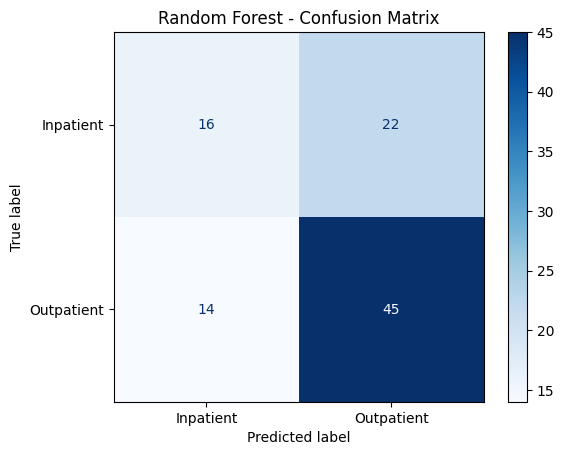

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
# ----- Random Forest Model -----
# Define the hyperparameter search space for the Random Forest
rf_params = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [10, 20, 30],
    'max_depth': [15, 20, 25],
    'min_samples_leaf': [2, 5, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Initialize the RandomForestClassifier
rf_base = RandomForestClassifier(random_state=42)

# Randomized search over the specified hyperparameter space
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_params,
    n_iter=10,
    cv=10,
    n_jobs=-1,
    scoring='f1_weighted',
    random_state=42
)

# Fit the randomized search on training data
rf_search.fit(X_train, y_train)

# Retrieve the best model from the search
rf_best = rf_search.best_estimator_

# Predict on the test set
y_pred_rf = rf_best.predict(X_test)

# Perform cross-validation on the base model first
rf_cv_accuracy = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='accuracy')
rf_cv_precision = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='precision_weighted')
rf_cv_recall = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='recall_weighted')
rf_cv_f1 = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='f1_weighted')

print("\n--- Random Forest Cross-Validation Results ---")
print(f"CV Accuracy: {np.mean(rf_cv_accuracy):.4f}")
print(f"CV Precision: {np.mean(rf_cv_precision):.4f}")
print(f"CV Recall: {np.mean(rf_cv_recall):.4f}")
print(f"CV F1 Score: {np.mean(rf_cv_f1):.4f}")

# Compute key performance metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\n--- Random Forest Evaluation on Test Set ---")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Inpatient', 'Outpatient'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest - Confusion Matrix")
plt.show()
print()


In [ ]:
# Create a DataFrame for visualization of predicted classes
predicted_labels = pd.Series(y_pred_rf).map({0: 'Inpatient', 1: 'Outpatient'})

# Count the predicted patient types
patient_counts = predicted_labels.value_counts()

# Bar chart visualization without the deprecation warning
plt.figure(figsize=(8, 5))
sns.barplot(x=patient_counts.index, y=patient_counts.values,
            hue=patient_counts.index, palette='pastel', legend=False)
plt.title('Predicted Number of Inpatients vs Outpatients (Random Forest)', fontsize=16)
plt.xlabel('Patient Type', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.show()

# Pie chart visualization
plt.figure(figsize=(7, 7))
plt.pie(patient_counts, labels=patient_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90, textprops={'fontsize': 14})
plt.title('Predicted Patient Type Distribution (Random Forest)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular.
plt.show()


--- Decision Tree Cross-Validation Results ---
CV Accuracy: 0.6587
CV Precision: 0.6794
CV Recall: 0.6587
CV F1 Score: 0.6483

--- Decision Tree Evaluation on Test Set ---
Accuracy: 0.6598
Precision: 0.6532
Recall: 0.6598
F1 Score: 0.6547

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        38
           1       0.70      0.76      0.73        59

    accuracy                           0.66        97
   macro avg       0.64      0.63      0.63        97
weighted avg       0.65      0.66      0.65        97



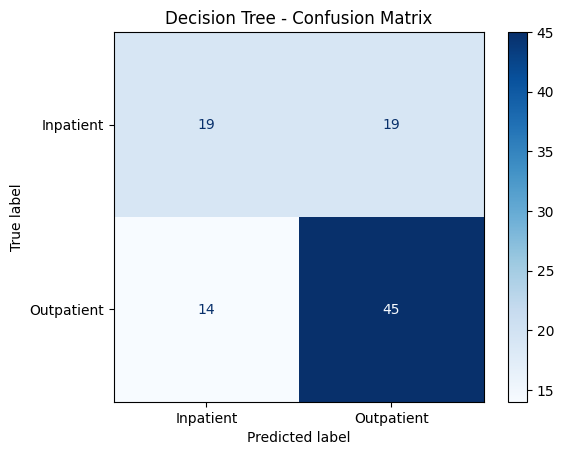

In [ ]:
# ----- Decision Tree Model -----
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier with selected hyperparameters
dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='gini'
)

# Train the model on the entire training set
dt.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt.predict(X_test)

# Using cross_val_score to perform cross-validation
dt_cv_accuracy = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
dt_cv_precision = cross_val_score(dt, X_train, y_train, cv=5, scoring='precision_weighted')
dt_cv_recall = cross_val_score(dt, X_train, y_train, cv=5, scoring='recall_weighted')
dt_cv_f1 = cross_val_score(dt, X_train, y_train, cv=5, scoring='f1_weighted')

# Output the results of cross-validation
print("\n--- Decision Tree Cross-Validation Results ---")
print(f"CV Accuracy: {np.mean(dt_cv_accuracy):.4f}")
print(f"CV Precision: {np.mean(dt_cv_precision):.4f}")
print(f"CV Recall: {np.mean(dt_cv_recall):.4f}")
print(f"CV F1 Score: {np.mean(dt_cv_f1):.4f}")

# Calculate performance metrics on the test set
acc_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("\n--- Decision Tree Evaluation on Test Set ---")
print(f"Accuracy: {acc_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Visualize the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[0, 1])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Inpatient', 'Outpatient'])
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree - Confusion Matrix")
plt.show()


In [ ]:
# Create a DataFrame for visualization of predicted classes
predicted_labels = pd.Series(y_pred_dt).map({0: 'Inpatient', 1: 'Outpatient'})

# Count the predicted patient types
patient_counts = predicted_labels.value_counts()

#  Bar chart visualization without the deprecation warning
plt.figure(figsize=(8, 5))
sns.barplot(x=patient_counts.index, y=patient_counts.values,
            hue=patient_counts.index, palette='pastel', legend=False)
plt.title('Predicted Number of Inpatients vs Outpatients (Decision Tree)', fontsize=16)
plt.xlabel('Patient Type', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.show()

# Pie chart visualization
plt.figure(figsize=(7, 7))
plt.pie(patient_counts, labels=patient_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90, textprops={'fontsize': 14})
plt.title('Predicted Patient Type Distribution (Decision Tree)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular.
plt.show()


Best K value: 30

--- KNN Cross-Validation Results ---
CV Accuracy: 0.6283
CV Precision: 0.6591
CV Recall: 0.6283
CV F1 Score: 0.6038

--- KNN Evaluation on Test Set ---
Accuracy: 0.5773
Precision: 0.5339
Recall: 0.5773
F1 Score: 0.5286

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.18      0.25        38
           1       0.61      0.83      0.71        59

    accuracy                           0.58        97
   macro avg       0.51      0.51      0.48        97
weighted avg       0.53      0.58      0.53        97



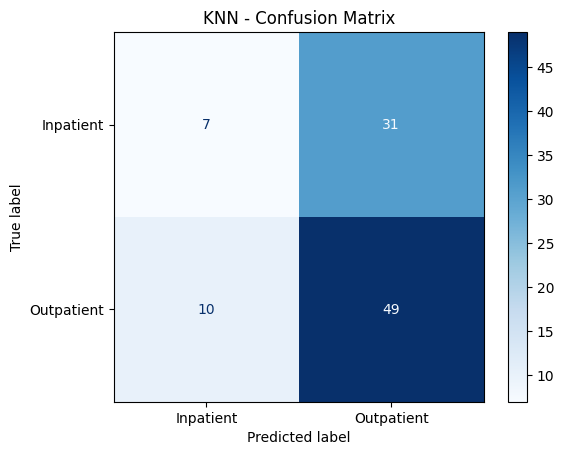

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Normalize the data using RobustScaler to reduce the effect of outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction (trying n_components=5)
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Find the best K value using Grid Search (expanding the range)
param_grid = {'n_neighbors': [25, 30, 35, 40, 45]}
grid_search = GridSearchCV(KNeighborsClassifier(weights='uniform'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_k = grid_search.best_params_['n_neighbors']
print("Best K value:", best_k)

# Train the final KNN model using the best K value found
knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='minkowski', p=2)
knn.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_pca)

# Perform cross-validation to evaluate the model
knn_cv_accuracy = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='accuracy')
knn_cv_precision = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='precision_weighted')
knn_cv_recall = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='recall_weighted')
knn_cv_f1 = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='f1_weighted')

# Print cross-validation results
print("\n--- KNN Cross-Validation Results ---")
print(f"CV Accuracy: {np.mean(knn_cv_accuracy):.4f}")
print(f"CV Precision: {np.mean(knn_cv_precision):.4f}")
print(f"CV Recall: {np.mean(knn_cv_recall):.4f}")
print(f"CV F1 Score: {np.mean(knn_cv_f1):.4f}")



# Compute key performance metrics for test set evaluation
acc_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Print test set evaluation results
print("\n--- KNN Evaluation on Test Set ---")
print(f"Accuracy: {acc_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# Visualize the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0, 1])
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Inpatient', 'Outpatient'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("KNN - Confusion Matrix")
plt.show()


In [ ]:
# Create a DataFrame for visualization of predicted classes
predicted_labels = pd.Series(y_pred_knn).map({0: 'Inpatient', 1: 'Outpatient'})

# Count the predicted patient types
patient_counts = predicted_labels.value_counts()

#  Bar chart visualization without the deprecation warning
plt.figure(figsize=(8, 5))
sns.barplot(x=patient_counts.index, y=patient_counts.values,
            hue=patient_counts.index, palette='pastel', legend=False)
plt.title('Predicted Number of Inpatients vs Outpatients (KNN)', fontsize=16)
plt.xlabel('Patient Type', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.show()

# Pie chart visualization
plt.figure(figsize=(7, 7))
plt.pie(patient_counts, labels=patient_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90, textprops={'fontsize': 14})
plt.title('Predicted Patient Type Distribution (KNN)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular.
plt.show()